In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from helpers import *
from Model import *
from cross_val import *
%matplotlib inline

from helpersLogistic import de_standardize
from plotsLogistic import *

# Data cleaning

In [2]:
#[yb_t, input_data_t, ids_t, yb_test, input_data_test, ids_test] = pickle.load(open( "dat.p", "rb" ))
# Import full data
(yb_t, input_data_t, ids_t) = load_csv_data('data/train.csv', sub_sample = False)
(yb_test, input_data_test, ids_test) = load_csv_data('data/test.csv',sub_sample = False)

# Replace missing data with nan
tx_tr_clean = clean_data(input_data_t)
y_tr_clean = clean_data(yb_t)
tx_te_clean = clean_data(input_data_test)
y_te_clean = clean_data(yb_test)

print('Train set shape ', tx_tr_clean.shape)
print('Test set shape ', tx_te_clean.shape)

Train set shape  (250000, 30)
Test set shape  (568238, 30)


# Data processing

In [3]:
# Extend categorical variable into three features
def extendCategorical(input_tx_train, input_tx_test):
    mask_tr_0 = (input_tx_train[:,22] == 0).astype(int).reshape((-1, 1))
    mask_tr_1 = (input_tx_train[:,22] == 1).astype(int).reshape((-1, 1))
    mask_tr_2 = (input_tx_train[:,22] == 2).astype(int).reshape((-1, 1))
    mask_tr_3 = (input_tx_train[:,22] == 3).astype(int).reshape((-1, 1))
    mask_te_0 = (input_tx_test[:,22] == 0).astype(int).reshape((-1, 1))
    mask_te_1 = (input_tx_test[:,22] == 1).astype(int).reshape((-1, 1))
    mask_te_2 = (input_tx_test[:,22] == 2).astype(int).reshape((-1, 1))
    mask_te_3 = (input_tx_test[:,22] == 3).astype(int).reshape((-1, 1))
    tx_train_cat = np.concatenate((mask_tr_0, mask_tr_1, mask_tr_2, mask_tr_3), axis = 1)
    tx_test_cat = np.concatenate((mask_te_0, mask_te_1, mask_te_2, mask_te_3), axis = 1)
    return tx_train_cat, tx_test_cat

# Arrays representing the categorical variable for both tx_train and tx_test
tx_tr_cat, tx_te_cat = extendCategorical(tx_tr_clean, tx_te_clean)
print("tx_tr_cat.shape = ", tx_tr_cat.shape)
print("tx_tr_cat[:,0] = ", tx_tr_cat[:, 0])
print("tx_tr_cat[:,1] = ", tx_tr_cat[:, 1])
print("tx_tr_cat[:,2] = ", tx_tr_cat[:, 2])
print("tx_tr_cat[:,3] = ", tx_tr_cat[:, 3])

tx_tr_cat.shape =  (250000, 4)
tx_tr_cat[:,0] =  [0 0 0 ..., 0 1 1]
tx_tr_cat[:,1] =  [0 1 1 ..., 1 0 0]
tx_tr_cat[:,2] =  [1 0 0 ..., 0 0 0]
tx_tr_cat[:,3] =  [0 0 0 ..., 0 0 0]


In [4]:
# Replacing missing values by their respective mean for each feature (computing for the TRAINING set only!)
def replaceByMeanPerFeature(input_tx_train, input_y_train, input_tx_test, input_y_test):
    train_mean = np.nanmean(input_tx_train, axis=0) # Computes the mean per column without considering nan value
    for ind, mean in enumerate(train_mean):
        mask_tmp = np.isnan(input_tx_train[:,ind])
        input_tx_train[mask_tmp, ind] = mean
        mask_tmp = np.isnan(input_tx_test[:,ind])
        input_tx_test[mask_tmp, ind] = mean
    y_train = input_y_train
    y_test = input_y_test
    return input_tx_train, y_train, input_tx_test, y_test

# We compute the mean per feature on the initial array
tx_tr_m, y_tr, tx_te_m, y_te = replaceByMeanPerFeature(tx_tr_clean, y_tr_clean, tx_te_clean, y_te_clean)

In [5]:
# Standardize data
print("tx_tr_m[:,22] = ", tx_tr_m[:,22])
# We delete the column 22 which doesn't mean anything
tx_tr = np.delete(tx_tr_m, 22, axis=1)
tx_tr_std, mean_tx_tr, std_tx_tr = standardize(tx_tr)

# Test data should be standardize wt respect to the mean and standard deviation of the training set
print("tx_te_m[:,22] = ", tx_te_m[:,22])
# We delete the column 22 which doesn't mean anything
tx_te = np.delete(tx_te_m, 22, axis=1)
tx_te_std = (tx_te - mean_tx_tr)/std_tx_tr

tx_tr_wt_cat = np.concatenate((tx_tr_std, tx_tr_cat), axis=1)
tx_te_wt_cat = np.concatenate((tx_te_std, tx_te_cat), axis = 1)
print("tx_tr_wt_cat.shape = ", tx_tr_wt_cat.shape)
print("tx_tr_wt_cat[:,29] = ", tx_tr_wt_cat[:, 29])
print("tx_tr_wt_cat[:,30] = ", tx_tr_wt_cat[:, 30])
print("tx_tr_wt_cat[:,31] = ", tx_tr_wt_cat[:, 31])
print("tx_tr_wt_cat[:,32] = ", tx_tr_wt_cat[:, 32])
y_tr = np.array([0 if p<0 else 1 for p in y_tr])

tx_tr_m[:,22] =  [ 2.  1.  1. ...,  1.  0.  0.]
tx_te_m[:,22] =  [ 0.  1.  0. ...,  0.  1.  0.]
tx_tr_wt_cat.shape =  (250000, 33)
tx_tr_wt_cat[:,29] =  [ 0.  0.  0. ...,  0.  1.  1.]
tx_tr_wt_cat[:,30] =  [ 0.  1.  1. ...,  1.  0.  0.]
tx_tr_wt_cat[:,31] =  [ 1.  0.  0. ...,  0.  0.  0.]
tx_tr_wt_cat[:,32] =  [ 0.  0.  0. ...,  0.  0.  0.]


In [6]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    poly = np.ones((len(x), 1))
    for deg in range(2, degree+1):
        poly = np.c_[poly, np.power(x, deg)]
    return poly[:, 1:]

def augment_feat(input_tx_train, input_tx_test, degree):
    n_features = len(input_tx_train[0])
    for ind in range(0, n_features):
        input_tx_train = np.c_[input_tx_train, build_poly(input_tx_train[:, ind], degree)]
        input_tx_test = np.c_[input_tx_test, build_poly(input_tx_test[:, ind], degree)]
    return input_tx_train, input_tx_test

# Fit data with Ridge Regression with no feature augmentation

In [7]:
from Model import ridge_regression

In [8]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
    plt.savefig("cross_validation")

min_rmse_te =  0.00164458799392


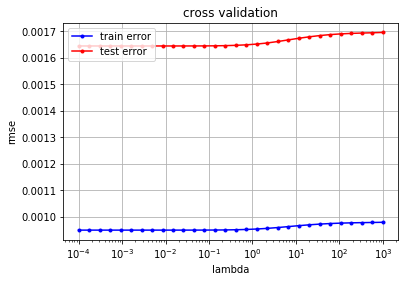

In [9]:
def cross_validation_demo():
    seed = 1
    degree = 1
    k_fold = 4
    lambdas = np.logspace(-4, 3, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation
    for ind, lambda_ in enumerate(lambdas):
        # define model
        model = ridge_regression(lambda_)
        losses_train, losses_test = cross_validation(model, y_tr, tx_tr_wt_cat, k_fold)
        tmp_tr = np.mean(losses_train)
        tmp_te = np.mean(losses_test)
        rmse_tr.append(tmp_tr)
        rmse_te.append(tmp_te)
    print("min_rmse_te = ", np.min(rmse_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

# Fit data with Ridge Regression with data augmentation

In [10]:
tx_tr_in = np.copy(tx_tr)
tx_te_in = np.copy(tx_te)
print("tx_tr_in[0] = ", tx_tr_in[0])
print("tx_te_in[0] = ", tx_te_in[0])

tx_tr_in[0] =  [  1.38470000e+02   5.16550000e+01   9.78270000e+01   2.79800000e+01
   9.10000000e-01   1.24711000e+02   2.66600000e+00   3.06400000e+00
   4.19280000e+01   1.97760000e+02   1.58200000e+00   1.39600000e+00
   2.00000000e-01   3.26380000e+01   1.01700000e+00   3.81000000e-01
   5.16260000e+01   2.27300000e+00  -2.41400000e+00   1.68240000e+01
  -2.77000000e-01   2.58733000e+02   6.74350000e+01   2.15000000e+00
   4.44000000e-01   4.60620000e+01   1.24000000e+00  -2.47500000e+00
   1.13497000e+02]
tx_te_in[0] =  [  1.21858528e+02   7.95890000e+01   2.39160000e+01   3.03600000e+00
   2.40373503e+00   3.71783360e+02  -8.21688171e-01   9.03000000e-01
   3.03600000e+00   5.60180000e+01   1.53600000e+00  -1.40400000e+00
   4.58289801e-01   2.20880000e+01  -5.40000000e-01  -6.09000000e-01
   3.39300000e+01  -5.04000000e-01  -1.51100000e+00   4.85090000e+01
   2.02200000e+00   9.85560000e+01   8.48221045e+01  -3.27458741e-03
  -1.23928255e-02   5.76794744e+01  -1.18452642e-02  -

In [11]:
tx_tr, tx_te = augment_feat(tx_tr_in, tx_te_in, 3)
tx_tr_wt_cat = np.concatenate((tx_tr, tx_tr_cat), axis=1)
tx_te_wt_cat = np.concatenate((tx_te, tx_te_cat), axis = 1)
print("tx_tr_wt_cat.shape = ", tx_tr_wt_cat.shape)

tx_tr_wt_cat.shape =  (250000, 91)


min_rmse_te =  0.00647316608912


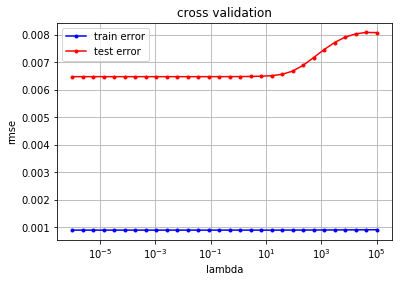

In [12]:
def cross_validation_demo():
    seed = 1
    degree = 1
    k_fold = 4
    lambdas = np.logspace(-6, 5, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation
    for ind, lambda_ in enumerate(lambdas):
        # define model
        model = ridge_regression(lambda_)
        losses_train, losses_test = cross_validation(model, y_tr, tx_tr_wt_cat, k_fold)
        tmp_tr = np.mean(losses_train)
        tmp_te = np.mean(losses_test)
        rmse_tr.append(tmp_tr)
        rmse_te.append(tmp_te)
    print("min_rmse_te = ", np.min(rmse_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()


# Fit data with Ridge Regression and augmenting features using square root of absolute value

In [13]:
def build_sqrt(x):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    sqrt = np.ones((len(x), 1))
    sqrt = np.c_[sqrt, np.sqrt(np.abs(x))]
    return sqrt[:, 1:]

def augment_feat_sqrt(input_tx_train, input_tx_test):
    n_features = len(input_tx_train[0])
    for ind in range(0, n_features):
        input_tx_train = np.c_[input_tx_train, build_sqrt(input_tx_train[:, ind])]
        input_tx_test = np.c_[input_tx_test, build_sqrt(input_tx_test[:, ind])]
    return input_tx_train, input_tx_test

In [14]:
print("tx_tr_in[0] = ", tx_tr_in[0])
print("tx_te_in[0] = ", tx_te_in[0])

tx_tr_in[0] =  [  1.38470000e+02   5.16550000e+01   9.78270000e+01   2.79800000e+01
   9.10000000e-01   1.24711000e+02   2.66600000e+00   3.06400000e+00
   4.19280000e+01   1.97760000e+02   1.58200000e+00   1.39600000e+00
   2.00000000e-01   3.26380000e+01   1.01700000e+00   3.81000000e-01
   5.16260000e+01   2.27300000e+00  -2.41400000e+00   1.68240000e+01
  -2.77000000e-01   2.58733000e+02   6.74350000e+01   2.15000000e+00
   4.44000000e-01   4.60620000e+01   1.24000000e+00  -2.47500000e+00
   1.13497000e+02]
tx_te_in[0] =  [  1.21858528e+02   7.95890000e+01   2.39160000e+01   3.03600000e+00
   2.40373503e+00   3.71783360e+02  -8.21688171e-01   9.03000000e-01
   3.03600000e+00   5.60180000e+01   1.53600000e+00  -1.40400000e+00
   4.58289801e-01   2.20880000e+01  -5.40000000e-01  -6.09000000e-01
   3.39300000e+01  -5.04000000e-01  -1.51100000e+00   4.85090000e+01
   2.02200000e+00   9.85560000e+01   8.48221045e+01  -3.27458741e-03
  -1.23928255e-02   5.76794744e+01  -1.18452642e-02  -

In [15]:
tx_tr, tx_te = augment_feat_sqrt(tx_tr_in, tx_te_in)
tx_tr_wt_cat = np.concatenate((tx_tr, tx_tr_cat), axis=1)
tx_te_wt_cat = np.concatenate((tx_te, tx_te_cat), axis = 1)
print("tx_tr_wt_cat.shape = ", tx_tr_wt_cat.shape)
print("tx_tr_wt_cat[:,58] = ", tx_tr_wt_cat[:, 58])
print("tx_tr_wt_cat[:,59] = ", tx_tr_wt_cat[:, 59])
print("tx_tr_wt_cat[:,60] = ", tx_tr_wt_cat[:, 60])
print("tx_tr_wt_cat[:,61] = ", tx_tr_wt_cat[:, 61])

tx_tr_wt_cat.shape =  (250000, 62)
tx_tr_wt_cat[:,58] =  [ 0.  0.  0. ...,  0.  1.  1.]
tx_tr_wt_cat[:,59] =  [ 0.  1.  1. ...,  1.  0.  0.]
tx_tr_wt_cat[:,60] =  [ 1.  0.  0. ...,  0.  0.  0.]
tx_tr_wt_cat[:,61] =  [ 0.  0.  0. ...,  0.  0.  0.]


min_rmse_te =  0.00157729525174


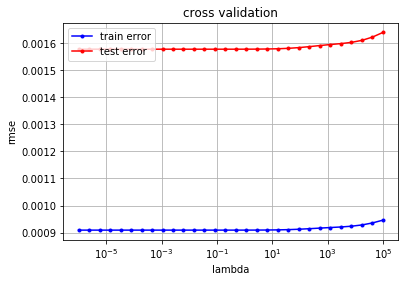

In [16]:
def cross_validation_demo():
    seed = 1
    degree = 1
    k_fold = 4
    lambdas = np.logspace(-6, 5, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation
    for ind, lambda_ in enumerate(lambdas):
        # define model
        model = ridge_regression(lambda_)
        losses_train, losses_test = cross_validation(model, y_tr, tx_tr_wt_cat, k_fold)
        tmp_tr = np.mean(losses_train)
        tmp_te = np.mean(losses_test)
        rmse_tr.append(tmp_tr)
        rmse_te.append(tmp_te)
    print("min_rmse_te = ", np.min(rmse_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

# Fit data with Ridge Regression and augmenting features using log

In [17]:
def build_log(x):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    log = np.ones((len(x), 1))
    log = np.c_[log, np.log(np.abs(x))]
    return log[:, 1:]

def augment_feat_log(input_tx_train, input_tx_test):
    n_features = len(input_tx_train[0])
    for ind in range(0, n_features):
        mask1 = ~np.any(input_tx_train[:, ind] < 0.001)
        mask2 = ~np.any(input_tx_test[:, ind] < 0.001)
        if (mask1 and mask2):
            print("Found appropriate feature")
            input_tx_train = np.c_[input_tx_train, build_log(input_tx_train[:, ind])]
            input_tx_test = np.c_[input_tx_test, build_log(input_tx_test[:, ind])]
    return input_tx_train, input_tx_test

In [18]:
print("tx_tr_in[0] = ", tx_tr_in[0])
print("tx_te_in[0] = ", tx_te_in[0])

tx_tr_in[0] =  [  1.38470000e+02   5.16550000e+01   9.78270000e+01   2.79800000e+01
   9.10000000e-01   1.24711000e+02   2.66600000e+00   3.06400000e+00
   4.19280000e+01   1.97760000e+02   1.58200000e+00   1.39600000e+00
   2.00000000e-01   3.26380000e+01   1.01700000e+00   3.81000000e-01
   5.16260000e+01   2.27300000e+00  -2.41400000e+00   1.68240000e+01
  -2.77000000e-01   2.58733000e+02   6.74350000e+01   2.15000000e+00
   4.44000000e-01   4.60620000e+01   1.24000000e+00  -2.47500000e+00
   1.13497000e+02]
tx_te_in[0] =  [  1.21858528e+02   7.95890000e+01   2.39160000e+01   3.03600000e+00
   2.40373503e+00   3.71783360e+02  -8.21688171e-01   9.03000000e-01
   3.03600000e+00   5.60180000e+01   1.53600000e+00  -1.40400000e+00
   4.58289801e-01   2.20880000e+01  -5.40000000e-01  -6.09000000e-01
   3.39300000e+01  -5.04000000e-01  -1.51100000e+00   4.85090000e+01
   2.02200000e+00   9.85560000e+01   8.48221045e+01  -3.27458741e-03
  -1.23928255e-02   5.76794744e+01  -1.18452642e-02  -

In [19]:
tx_tr, tx_te = augment_feat_log(tx_tr_in, tx_te_in)
tx_tr_wt_cat = np.concatenate((tx_tr, tx_tr_cat), axis=1)
tx_te_wt_cat = np.concatenate((tx_te, tx_te_cat), axis = 1)
print("tx_tr.shape = ", tx_tr.shape)
print("tx_te_shape = ", tx_te.shape)

Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
tx_tr.shape =  (250000, 41)
tx_te_shape =  (568238, 41)


min_rmse_te =  0.00159257785681


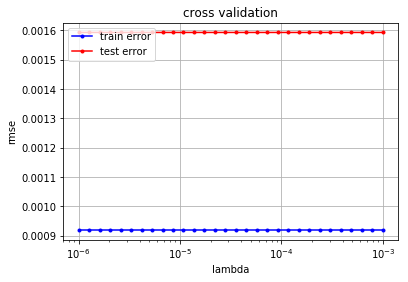

In [20]:
def cross_validation_demo():
    seed = 1
    degree = 1
    k_fold = 4
    lambdas = np.logspace(-6, -3, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation
    for ind, lambda_ in enumerate(lambdas):
        # define model
        model = ridge_regression(lambda_)
        losses_train, losses_test = cross_validation(model, y_tr, tx_tr_wt_cat, k_fold)
        tmp_tr = np.mean(losses_train)
        tmp_te = np.mean(losses_test)
        rmse_tr.append(tmp_tr)
        rmse_te.append(tmp_te)
    print("min_rmse_te = ", np.min(rmse_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

In [21]:
model = ridge_regression(1e-6)
model.fit(y_tr, tx_tr_wt_cat)
y_pred_test = model.predict(tx_te_wt_cat)

y_pred_bin = np.array([-1 if p<0.5 else 1 for p in y_pred_test])
print("sum = ", np.sum(y_pred_bin))

create_csv_submission(ids_test, y_pred_bin, 'sub3.csv')

sum =  -244780


# Fit data with Ridge Regression and inverse

In [22]:
def build_inv(x):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    inv = np.ones((len(x), 1))
    inv = np.c_[inv, 1/x]
    return inv[:, 1:]

def augment_feat_inv(input_tx_train, input_tx_test):
    n_features = len(input_tx_train[0])
    for ind in range(0, n_features):
        mask1 = ~np.any(input_tx_train[:, ind] < 0.01)
        #mask_test = input_tx_train[:, ind] < 0.01
        #print(mask_test)
        #print("For iteration i = ", ind,  input_tx_train[:,ind][mask_test])
        mask2 = ~np.any(input_tx_test[:, ind] < 0.01)
        if (mask1 and mask2):
            print("Found appropriate feature")
            input_tx_train = np.c_[input_tx_train, build_inv(input_tx_train[:, ind])]
            input_tx_test = np.c_[input_tx_test, build_inv(input_tx_test[:, ind])]
    return input_tx_train, input_tx_test

In [23]:
print("tx_tr_in[0] = ", tx_tr_in[0])
print("tx_te_in[0] = ", tx_te_in[0])

tx_tr_in[0] =  [  1.38470000e+02   5.16550000e+01   9.78270000e+01   2.79800000e+01
   9.10000000e-01   1.24711000e+02   2.66600000e+00   3.06400000e+00
   4.19280000e+01   1.97760000e+02   1.58200000e+00   1.39600000e+00
   2.00000000e-01   3.26380000e+01   1.01700000e+00   3.81000000e-01
   5.16260000e+01   2.27300000e+00  -2.41400000e+00   1.68240000e+01
  -2.77000000e-01   2.58733000e+02   6.74350000e+01   2.15000000e+00
   4.44000000e-01   4.60620000e+01   1.24000000e+00  -2.47500000e+00
   1.13497000e+02]
tx_te_in[0] =  [  1.21858528e+02   7.95890000e+01   2.39160000e+01   3.03600000e+00
   2.40373503e+00   3.71783360e+02  -8.21688171e-01   9.03000000e-01
   3.03600000e+00   5.60180000e+01   1.53600000e+00  -1.40400000e+00
   4.58289801e-01   2.20880000e+01  -5.40000000e-01  -6.09000000e-01
   3.39300000e+01  -5.04000000e-01  -1.51100000e+00   4.85090000e+01
   2.02200000e+00   9.85560000e+01   8.48221045e+01  -3.27458741e-03
  -1.23928255e-02   5.76794744e+01  -1.18452642e-02  -

In [24]:
tx_tr, tx_te = augment_feat_inv(tx_tr_in, tx_te_in)
tx_tr_wt_cat = np.concatenate((tx_tr, tx_tr_cat), axis=1)
tx_te_wt_cat = np.concatenate((tx_te, tx_te_cat), axis = 1)
print("tx_tr.shape = ", tx_tr.shape)
print("tx_te_shape = ", tx_te.shape)

Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
tx_tr.shape =  (250000, 41)
tx_te_shape =  (568238, 41)


min_rmse_te =  0.00159781112211


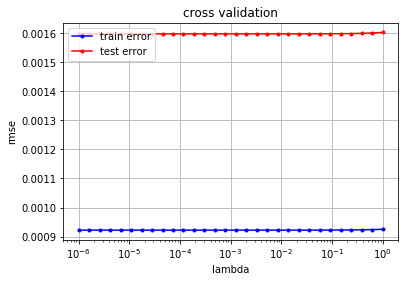

In [25]:
def cross_validation_demo():
    seed = 1
    degree = 1
    k_fold = 4
    lambdas = np.logspace(-6, 0, 30)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation
    for ind, lambda_ in enumerate(lambdas):
        # define model
        model = ridge_regression(lambda_)
        losses_train, losses_test = cross_validation(model, y_tr, tx_tr_wt_cat, k_fold)
        tmp_tr = np.mean(losses_train)
        tmp_te = np.mean(losses_test)
        rmse_tr.append(tmp_tr)
        rmse_te.append(tmp_te)
    print("min_rmse_te = ", np.min(rmse_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

# Fit with Ridge and combining useful data augmentation

In [32]:
tx_tr_sqr, tx_te_sqr = augment_feat_sqrt(tx_tr_in, tx_te_in)
tx_tr_log, tx_te_log = augment_feat_log(tx_tr_sqr, tx_te_sqr)
tx_tr_inv, tx_te_inv = augment_feat_inv(tx_tr_log, tx_te_log)
tx_tr_wt_cat = np.concatenate((tx_tr_inv, tx_tr_cat, np.ones((len(tx_tr_wt_cat),1))), axis=1)
tx_te_wt_cat = np.concatenate((tx_te_inv, tx_te_cat, np.ones((len(tx_te_wt_cat),1))), axis = 1)
print("tx_tr_wt_cat.shape = ", tx_tr_wt_cat.shape)
print("tx_te_wt_cat.shape = ", tx_te_wt_cat.shape)

Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found appropriate feature
Found approp

min_rmse_te =  0.0015292121672


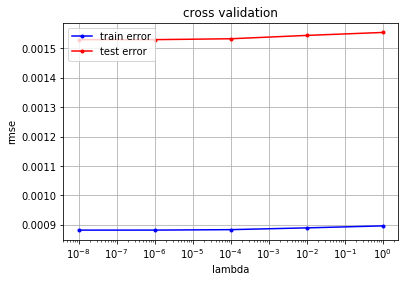

In [33]:
def cross_validation_demo():
    seed = 1
    degree = 1
    k_fold = 4
    lambdas = np.logspace(-8, 0, 5)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation
    for ind, lambda_ in enumerate(lambdas):
        # define model
        model = ridge_regression(lambda_)
        losses_train, losses_test = cross_validation(model, y_tr, tx_tr_wt_cat, k_fold)
        tmp_tr = np.mean(losses_train)
        tmp_te = np.mean(losses_test)
        rmse_tr.append(tmp_tr)
        rmse_te.append(tmp_te)
    print("min_rmse_te = ", np.min(rmse_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

In [48]:
model_y = ridge_regression(1e-8)
model_y.fit(y_tr, tx_tr_wt_cat)
y_pred_train = model_y.predict(tx_tr_wt_cat)

err = y_tr - y_pred_train
print("err = ", err)

err =  [ 0.61062324 -0.52261094 -0.33511811 ...,  0.59600883 -0.4651856
 -0.28042548]


min_rmse_te =  0.00152840719423


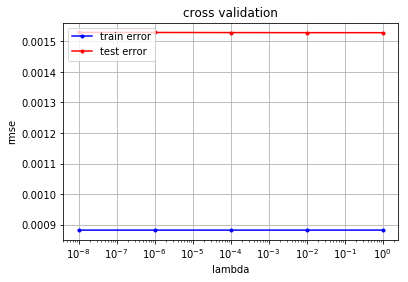

In [49]:
def cross_validation_demo():
    seed = 1
    degree = 1
    k_fold = 4
    lambdas = np.logspace(-8, 0, 5)
    
    # split data in k fold
    k_indices = build_k_indices(y_tr, k_fold, seed)
    
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    
    # cross validation
    for ind, lambda_ in enumerate(lambdas):
        # define model
        model = ridge_regression(lambda_)
        losses_train, losses_test = cross_validation(model, err, tx_tr_wt_cat, k_fold)
        tmp_tr = np.mean(losses_train)
        tmp_te = np.mean(losses_test)
        rmse_tr.append(tmp_tr)
        rmse_te.append(tmp_te)
    print("min_rmse_te = ", np.min(rmse_te))
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)

cross_validation_demo()

In [50]:
model_err = ridge_regression(1e-8)
model_err.fit(err, tx_tr_wt_cat)
err_pred = model_err.predict(tx_tr_wt_cat)

sol_pred = y_pred_train + err_pred
rmse_tr = np.sqrt(2*model_err.compute_loss(y_tr-sol_pred))
print("rmse_tr = ", rmse_tr)

rmse_tr =  0.000763913783121


In [51]:
sol_pred = model_y.predict(tx_te_wt_cat) + model_err.predict(tx_te_wt_cat)

y_pred_bin = np.array([-1 if p<0.5 else 1 for p in sol_pred])
print("len = ", len(y_pred_bin))

create_csv_submission(ids_test, y_pred_bin, 'dble_ridge.csv')

len =  568238
